In [20]:
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from skimage import color, io, exposure
from skimage.transform import resize
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from skimage.graph import cut_normalized, rag_mean_color
from skimage.segmentation import slic

We implement the Mean Shift algorithm from scratch to segment the images, by following these steps in the below function:

Parameters:
The function accepts an input image and parameters:
    \begin{itemize}
        \item \texttt{spatial\_radius}: Defines the spatial distance for considering nearby pixels.
        \item \texttt{color\_radius}: Defines the color intensity difference for grouping pixels.
        \item \texttt{max\_iterations}: Limits the number of iterations for convergence.
        \item \texttt{epsilon}: Sets the convergence threshold.
        \item \texttt{downscale\_factor}: Reduces the image size for faster processing.

In [14]:
def mean_shift_segmentation(image, spatial_radius=20, color_radius=50, max_iterations=10, epsilon=1, downscale_factor=0.5):

    # Downsample
    small_image = cv2.resize(image, None, fx=downscale_factor, fy=downscale_factor, interpolation=cv2.INTER_LINEAR)
    small_image = np.float32(small_image)
    rows, cols, channels = small_image.shape
    segmented_image = np.zeros_like(small_image)
    
    # Iterate over pixels 
    for y in range(rows):
        for x in range(cols):

            mean = small_image[y, x].copy()
            iteration = 0
            
            while iteration < max_iterations:
                # spatial and color window around the mean
                y_min = max(0, y - spatial_radius)
                y_max = min(rows, y + spatial_radius)
                x_min = max(0, x - spatial_radius)
                x_max = min(cols, x + spatial_radius)
                
                # Extract region of interest
                roi = small_image[y_min:y_max, x_min:x_max]
                
                # Gaussian weights based on color distance
                color_diff = np.linalg.norm(roi - mean, axis=2)
                mask = color_diff < color_radius
                points_within_radius = roi[mask]
                weights = np.exp(-0.5 * (color_diff[mask] / color_radius)**2)
                weighted_mean = np.average(points_within_radius, axis=0, weights=weights)
                
                # update
                shift_distance = np.linalg.norm(weighted_mean - mean)
                mean = weighted_mean
                if shift_distance < epsilon:
                    break
                
                iteration += 1
            

            segmented_image[y, x] = mean

    # Upscale back to original size
    segmented_image = cv2.resize(np.uint8(segmented_image), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    return segmented_image

**Parameters:**

The function accepts an input image and parameters:


- spatial_radius: The spatial distance for considering nearby pixels.

- color_radius: The color intensity difference for grouping pixels.

- max_iterations: Limits the number of iterations for convergence.

- epsilon: Sets the convergence threshold.

- downscale_factor: Reduces the image size for faster processing.


                                                           
**Downsample Image:**
                                                           
The input image is resized to improve computational efficiency.
    


**Mean Shift Iterations:**

For each pixel in the downscaled image:

- Initialize the mean value to the pixel’s color value.

- Define a spatial window around the pixel based on spatial_radius.

- Identify pixels with color differences below color_radius in the window.

- Calculate a weighted mean of the colors within this window and update the mean value.

- Repeat until convergence (based on epsilon) or until reaching max_iterations.

    
**Assigning Cluster Centers:**
                                                           
After convergence is achieved for a pixel, assign the mean color to the corresponding position in segmented_image.
    

                                                           
**Upscale and Return:**
                                                           
Resize the segmented_image back to the original image dimensions.

In [15]:
image = cv2.imread('/scratch/ne2213/computer-vision/stop.jpg')
segmented_image = mean_shift_segmentation(image, spatial_radius=30, color_radius=150, downscale_factor=0.5)

We visualize the results as below

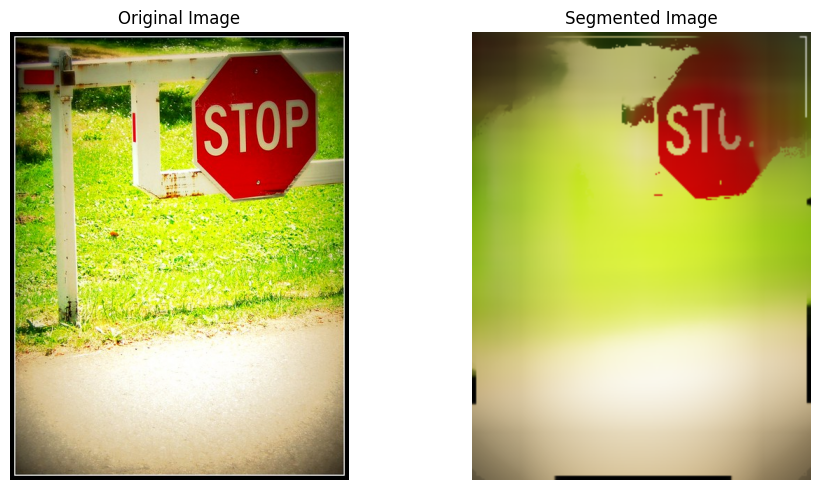

In [16]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image_rgb)
plt.title('Segmented Image')
plt.axis('off')

plt.tight_layout()
plt.show()

To compare our method with the Mean Shift algorithm implemented in OpenCV (cv2.pyrMeanShiftFiltering), we also applied the cv2 version to our input image:

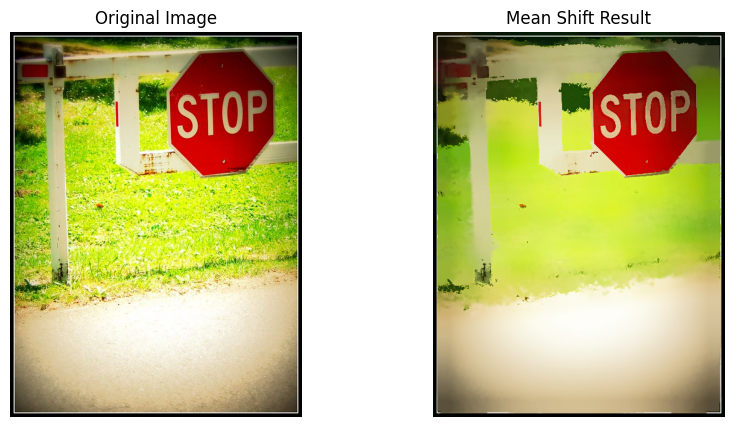

In [17]:
# Convert to Luv color space for better color clustering
image_luv = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)

# Apply Mean Shift
spatial_radius = 20  
color_radius = 40    
max_level = 1   

# mean shift filtering
mean_shift_result = cv2.pyrMeanShiftFiltering(image_luv, spatial_radius, color_radius, max_level)

# Convert back to RGB for displaying with matplotlib
result_image = cv2.cvtColor(mean_shift_result, cv2.COLOR_LUV2BGR)
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_image_rgb)
plt.title('Mean Shift Result')
plt.axis('off')

plt.show()

We can see the results are slightly better using the cv2 library, but the difference is minimal.

Next, we implement the Normalized Graph Cut method from scratch to segment the images:

In [25]:
def compute_similarity_matrix(image, sigma_I=0.1, sigma_x=0.1):
    height, width, channels = image.shape
    N = height * width
    W = np.zeros((N, N))
    flat_image = image.reshape(N, channels)
    coords = np.array([(i, j) for i in range(height) for j in range(width)])

    # color intensity differences and spatial distances
    intensity_diffs = cdist(flat_image, flat_image, 'euclidean') ** 2
    spatial_dists = cdist(coords, coords, 'euclidean') ** 2

    # Gaussian function to compute similarities
    W = np.exp(-intensity_diffs / (2 * sigma_I ** 2) - spatial_dists / (2 * sigma_x ** 2))

    return W

def normalized_graph_cut(image, downscale_size=(64, 64), n_clusters=2):

    image_resized = np.stack([resize(image[..., i], downscale_size, anti_aliasing=True) for i in range(image.shape[-1])], axis=-1)

    # similarity matrix using color channels
    W = compute_similarity_matrix(image_resized)
    D = np.diag(W.sum(axis=1))
    L = np.eye(W.shape[0]) - np.linalg.inv(D) @ W

    # the second smallest eigenvector of L
    _, eigvecs = eigh(L, subset_by_index=[1, 2])
    fiedler_vector = eigvecs[:, 0]

    # Segment the graph based on clustering the Fiedler vector values
    kmeans = KMeans(n_clusters=n_clusters).fit(fiedler_vector.reshape(-1, 1))
    segmentation = kmeans.labels_.reshape(downscale_size)

    # Resize to original image size
    segmentation_resized = resize(segmentation, (image.shape[0], image.shape[1]), order=0, anti_aliasing=False)

    return (np.flipud(segmentation_resized))

We call this function to get the final segmentation results:

In [26]:
input_image = io.imread('/scratch/ne2213/computer-vision/stop.jpg')
segmented_image = normalized_graph_cut(input_image)

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We plot the results as below, which we can see segments the stop sign reasonably

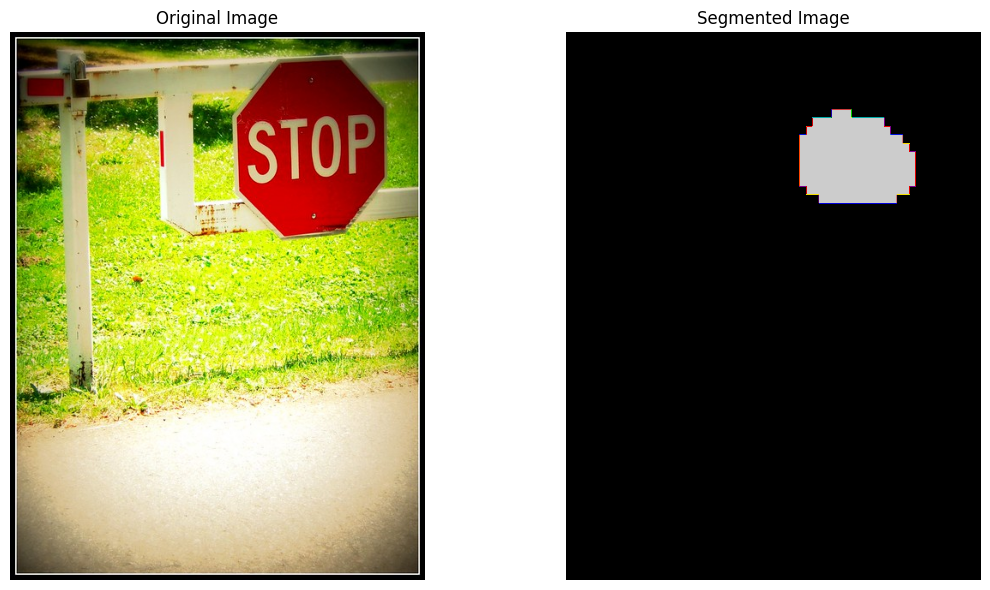

In [27]:
# Plot the original and  segmented images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(input_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(segmented_image, cmap='nipy_spectral')
axes[1].set_title("Segmented Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

To compare, we also applied the Normalized Graph Cut algorithm from skimage (skimage.graph.cut_normalized) on the same image, which resulted in the following output:

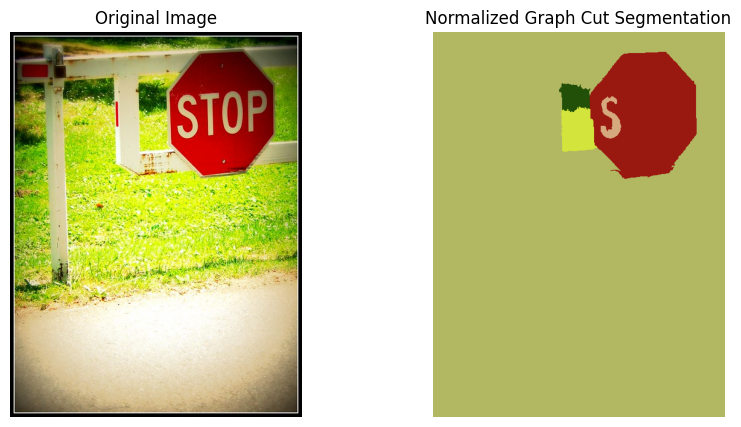

In [30]:
# Convert to LAB color space for better segmentation
image_lab = color.rgb2lab(input_image)

# SLIC to generate superpixels
segments_slic = slic(image_lab, n_segments=500, compactness=15, start_label=1)

# Region Adjacency Graph
rag = rag_mean_color(image_lab, segments_slic, mode='similarity')

# Normalized Graph Cut
labels = cut_normalized(segments_slic, rag)

# Convert back to RGB for visualization
out_image = color.label2rgb(labels, input_image, kind='avg', bg_label=0)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(out_image)
plt.title('Normalized Graph Cut Segmentation')
plt.axis('off')

plt.show()


We can see the results are better using the skimage library, but our implementation from scratch also provides reasonable and acceptable results.